In [274]:
# Sources used - 
# https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/layers/normalization/instancenormalization.py
# https://www.youtube.com/watch?v=2MSGnkir9ew

In [275]:
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import glob
import cv2

In [276]:
from keras.layers import Conv2D, LeakyReLU, ReLU, Conv2DTranspose, Input, Concatenate, Activation
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.initializers import RandomNormal
from instancenormalization import InstanceNormalization

In [277]:
def define_discriminator(image_shape):

	init = RandomNormal(stddev=0.02)   # to initialize the weights randomly with sd=0.02 and mean=0.0
	
	input_image = Input(shape=image_shape)
	
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(input_image)
	d = LeakyReLU(alpha=0.2)(d)
	
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	
	# second last output layer : 4x4 kernel but Stride 1x1    
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	
	# patch output
	patch_output = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	#(All layers according to the official paper on cycleGANs.)
	
	# define model
	model = Model(input_image, patch_output)
	
	# compile model
    # The loss for the discriminator is weighted by 50% for each model update.
    # This slows down changes to the discriminator relative to the generator model during training.
	# This is done because usually the descriminator trains faster than the generator.
	model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999), loss_weights=[0.5])
	
	return model

In [278]:
# residual block that contains two 3 × 3 convolutional layers with the same number of filters on both layers.
# to be used in the generator.
def resnet_block(n_filters, input_layer):
	
	init = RandomNormal(stddev=0.02)

	# first convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

In [279]:
# c7s1-k denote a 7×7 Convolution-InstanceNorm-ReLU layer with k filters and stride 1. 
# dk denotes a 3 × 3 Convolution-InstanceNorm-ReLU layer with k filters and stride 2.
# Rk denotes a residual block that contains two 3 × 3 convolutional layers
# uk denotes a 3 × 3 fractional-strided-Convolution InstanceNorm-ReLU layer with k filters and stride 1/2

#The network with 6 residual blocks consists of:
#c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,u128,u64,c7s1-3

#The network with 9 residual blocks consists of:
#c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,R256,R256,R256,u128, u64,c7s1-3

def define_generator(image_shape, n_resnet=9):

	init = RandomNormal(stddev=0.02)
	
	input_image = Input(shape=image_shape)

	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(input_image)
	g = InstanceNormalization(axis=-1)(g)
	g = ReLU()(g)

	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = ReLU()(g)

	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = ReLU()(g)

	# R256
	for _ in range(n_resnet):     # 9 residual network.
		g = resnet_block(256, g)

	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = ReLU()(g)

	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = ReLU()(g)

	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	output_image = Activation('tanh')(g)

	# define model
	model = Model(input_image, output_image)
	
	return model

In [280]:
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# Updating the parameters of one generator at a time making the others non-trainable at that instant.
	g_model_1.trainable = True
	d_model.trainable = False
	g_model_2.trainable = False
    
	# adversarial loss
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)

	# identity loss
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)

	# cycle loss - forward
	output_f = g_model_2(gen1_out)

	# cycle loss - backward
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
    
	# define model 
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10],
			      optimizer=Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999))
	
	return model

In [281]:
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random images.
	ix = np.random.randint(0, dataset.shape[0], n_samples)

	# retrieve selected images.
	X = dataset[ix]

	# create 'real' class labels (1)
	y = np.ones((n_samples, patch_shape, patch_shape, 1))

	return X, y

In [282]:
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake images.
	X = g_model.predict(dataset)

	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))

	return X, y

In [283]:
# periodically generate images using the save model and plot input and output images
def summarize_performance(step, g_model, trainX, name, n_samples=5):

	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)

	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)

	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0

	plt.figure(figsize=(10, 5))
	# plot real images
	for i in range(n_samples):
		plt.subplot(2, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		plt.subplot(2, n_samples, 1 + n_samples + i)    #since it has already run for n_samples number of times.
		plt.axis('off')
		plt.imshow(X_out[i])

	# display the plot
	plt.suptitle(name)
	plt.show()
	plt.close()

In [284]:
# update image pool for fake images to reduce model oscillation
# update discriminators using a history of generated images 
#rather than the ones produced by the latest generators.
#Original paper recommended keeping an image buffer that stores 
#the 50 previously created images.

In [285]:
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif np.random.rand() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = np.random.randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return np.asarray(selected)

In [286]:
# Here, A = Summer and B = Winter.

# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=5):

	n_epochs, n_batch = epochs, 1  #batch size fixed to 1 as suggested in the paper

	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]

	# unpack dataset
	trainA, trainB = dataset

	# prepare image pool for fake images
	poolA, poolB = list(), list()

	# calculate the number of batches per training epoch
	bat_per_epo = 50          
	# (ideally it must be equal to the number of images but it would have taken over a day of continuous training for my pc which isn't possible:/)

	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
    
	for i in range(n_steps):

		# select a batch of real samples from each domain (A and B)
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)

		# generate a batch of fake samples using both B to A and A to B generators.
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)

		# update fake images in the pool. Remember that the paper suggests a buffer of 50 images
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
        
		# update generator B->A via the composite model
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		
        # update generator A->B via the composite model
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		
        # summarize performance
		print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		
		if (i+1) % (bat_per_epo) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'SummertoWinter')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'WintertoSummer')


In [287]:
trainA = []
files = glob.glob("trainA\*.jpg")
for myFile in files:
    print(myFile)
    image = cv2.imread (myFile)
    trainA.append (image)

trainA\2009-12-06 06_58_39.jpg
trainA\2009-12-24 12_09_12.jpg
trainA\2010-02-21 16_52_39.jpg
trainA\2010-07-03 22_53_07.jpg
trainA\2010-07-13 22_34_03.jpg
trainA\2010-08-07 10_18_22.jpg
trainA\2010-08-10 00_15_25.jpg
trainA\2010-08-24 17_43_18.jpg
trainA\2010-09-02 18_48_52.jpg
trainA\2010-09-09 11_41_45.jpg
trainA\2010-09-11 03_15_45.jpg
trainA\2010-09-17 14_59_04.jpg
trainA\2010-09-21 06_41_59.jpg
trainA\2010-10-09 15_56_24.jpg
trainA\2010-11-08 17_33_13.jpg
trainA\2011-01-19 14_17_29.jpg
trainA\2011-01-23 00_06_43.jpg
trainA\2011-02-15 14_41_35.jpg
trainA\2011-02-28 14_43_59.jpg
trainA\2011-04-11 12_59_33.jpg
trainA\2011-05-04 08_59_56.jpg
trainA\2011-05-15 10_58_57.jpg
trainA\2011-05-15 18_05_22.jpg
trainA\2011-05-17 01_22_15.jpg
trainA\2011-05-17 15_09_34.jpg
trainA\2011-05-19 11_26_37.jpg
trainA\2011-05-19 17_27_18.jpg
trainA\2011-05-21 00_00_03.jpg
trainA\2011-05-21 09_22_37.jpg
trainA\2011-05-21 13_16_46.jpg
trainA\2011-05-22 14_56_17.jpg
trainA\2011-05-22 17_18_42.jpg
trainA\2

In [288]:
trainB = []
files = glob.glob("trainB\*.jpg")
for myFile in files:
    print(myFile)
    image = cv2.imread (myFile)
    trainB.append (image)

trainB\2005-06-26 14_04_52.jpg
trainB\2005-08-02 09_19_52.jpg
trainB\2005-08-10 13_03_58.jpg
trainB\2005-09-01 10_05_22.jpg
trainB\2006-02-26 17_07_52.jpg
trainB\2006-03-14 21_56_17.jpg
trainB\2006-03-20 23_39_46.jpg
trainB\2006-07-05 20_27_58.jpg
trainB\2006-07-16 14_00_05.jpg
trainB\2006-09-26 21_50_33.jpg
trainB\2006-12-24 08_44_26.jpg
trainB\2007-01-15 20_05_43.jpg
trainB\2007-01-23 19_32_24.jpg
trainB\2007-01-27 00_13_15.jpg
trainB\2007-02-28 14_15_05.jpg
trainB\2007-03-06 10_22_16.jpg
trainB\2007-03-16 21_52_46.jpg
trainB\2007-04-05 00_31_04.jpg
trainB\2007-04-30 20_41_22.jpg
trainB\2007-06-06 03_56_19.jpg
trainB\2007-06-21 18_15_16.jpg
trainB\2007-08-27 22_57_52.jpg
trainB\2007-09-12 08_05_38.jpg
trainB\2007-09-12 14_05_14.jpg
trainB\2007-09-25 13_22_25.jpg
trainB\2007-10-16 14_04_05.jpg
trainB\2007-10-17 02_48_15.jpg
trainB\2007-10-20 10_55_45.jpg
trainB\2007-12-16 07_54_17.jpg
trainB\2008-01-08 20_39_08.jpg
trainB\2008-01-19 07_55_07.jpg
trainB\2008-01-19 08_51_37.jpg
trainB\2

In [289]:
trainA = np.asarray(trainA)
trainA = (trainA - trainA.min())/(trainA.max() - trainA.min())

In [290]:
trainB = np.asarray(trainB)
trainB = (trainB - trainB.min())/(trainB.max() - trainB.min())

In [291]:
# load image data
dataset = [trainA, trainB]
print('Loaded:', dataset[0].shape,',', dataset[1].shape)

Loaded: (1231, 256, 256, 3) , (962, 256, 256, 3)


In [292]:
image_shape = dataset[0].shape[1:]          # (256, 256, 3)

d_model_A = define_discriminator(image_shape)
d_model_B = define_discriminator(image_shape)
g_model_AtoB = define_generator(image_shape)
g_model_BtoA = define_generator(image_shape)

# define the composite models
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

1/1 [==============================] - 2s 2s/step
Iteration>1, dA[1.159,0.955] dB[1.667,1.120] g[19.107,18.584]
1/1 [==============================] - 1s 1s/step
Iteration>2, dA[8.650,1.812] dB[13.848,1.662] g[19.428,21.381]
1/1 [==============================] - 1s 1s/step
Iteration>3, dA[2.301,1.278] dB[6.656,1.484] g[19.356,18.703]
1/1 [==============================] - 1s 1s/step
Iteration>4, dA[0.952,8.307] dB[2.020,2.998] g[25.134,28.183]
1/1 [==============================] - 1s 1s/step
Iteration>5, dA[0.838,2.918] dB[1.547,2.514] g[18.022,18.881]
1/1 [==============================] - 1s 1s/step
Iteration>6, dA[1.520,1.356] dB[0.827,1.044] g[13.599,15.180]
1/1 [==============================] - 1s 1s/step
Iteration>7, dA[2.311,0.830] dB[0.826,0.722] g[15.245,15.435]
1/1 [==============================] - 1s 1s/step
Iteration>8, dA[0.771,1.092] dB[0.749,0.854] g[12.855,13.698]
1/1 [==============================] - 1s 1s/step
Iteration>9, dA[0.490,0.423] dB[0.701,0.783] g[16.120

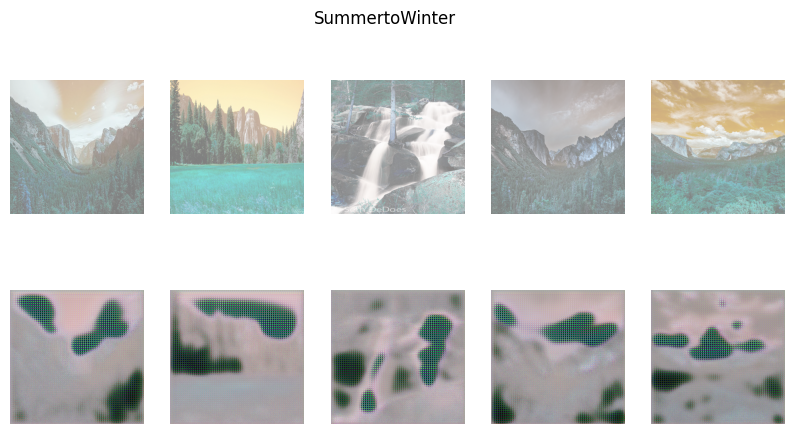

1/1 [==============================] - 26s 26s/step


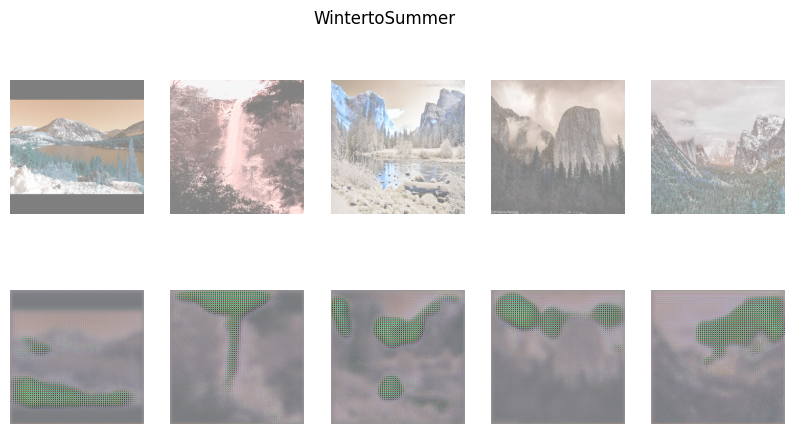

1/1 [==============================] - 1s 1s/step
Iteration>51, dA[0.175,0.117] dB[0.101,0.153] g[6.566,5.711]
1/1 [==============================] - 1s 1s/step
Iteration>52, dA[0.087,0.144] dB[0.185,0.119] g[7.034,6.595]
1/1 [==============================] - 1s 1s/step
Iteration>53, dA[0.174,0.102] dB[0.120,0.123] g[5.982,6.389]
1/1 [==============================] - 1s 1s/step
Iteration>54, dA[0.086,0.100] dB[0.137,0.096] g[5.955,6.170]
1/1 [==============================] - 1s 1s/step
Iteration>55, dA[0.105,0.108] dB[0.125,0.078] g[11.296,10.805]
1/1 [==============================] - 1s 1s/step
Iteration>56, dA[0.095,0.098] dB[0.111,0.028] g[7.721,8.002]
1/1 [==============================] - 1s 1s/step
Iteration>57, dA[0.105,0.072] dB[0.122,0.058] g[8.767,8.965]
1/1 [==============================] - 1s 1s/step
Iteration>58, dA[0.209,0.092] dB[0.066,0.132] g[8.126,7.431]
1/1 [==============================] - 1s 1s/step
Iteration>59, dA[0.074,0.176] dB[0.164,0.459] g[9.462,9.358]

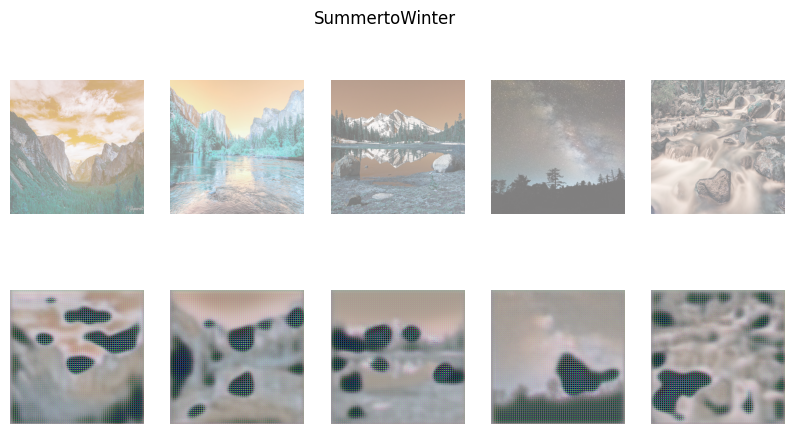

1/1 [==============================] - 5s 5s/step


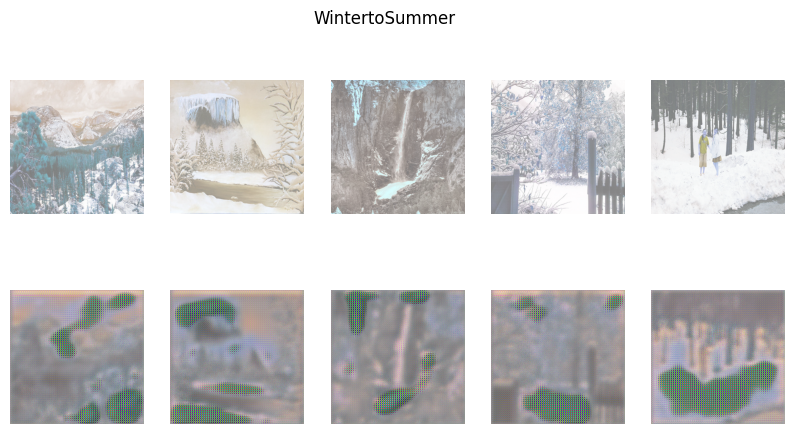

1/1 [==============================] - 1s 1s/step
Iteration>101, dA[0.091,0.183] dB[0.119,0.074] g[11.371,10.865]
1/1 [==============================] - 1s 1s/step
Iteration>102, dA[0.070,0.090] dB[0.244,0.121] g[7.375,7.478]
1/1 [==============================] - 1s 1s/step
Iteration>103, dA[0.046,0.048] dB[0.128,0.139] g[7.133,7.581]
1/1 [==============================] - 1s 1s/step
Iteration>104, dA[0.090,0.055] dB[0.096,0.135] g[8.292,7.792]
1/1 [==============================] - 1s 1s/step
Iteration>105, dA[0.057,0.091] dB[0.099,0.103] g[8.969,8.871]
1/1 [==============================] - 1s 1s/step
Iteration>106, dA[0.075,0.049] dB[0.036,0.084] g[8.096,8.097]
1/1 [==============================] - 1s 1s/step
Iteration>107, dA[0.053,0.089] dB[0.135,0.108] g[6.423,6.500]
1/1 [==============================] - 1s 1s/step
Iteration>108, dA[0.082,0.118] dB[0.116,0.121] g[7.627,7.531]
1/1 [==============================] - 1s 1s/step
Iteration>109, dA[0.031,0.188] dB[0.075,0.223] g[8.4

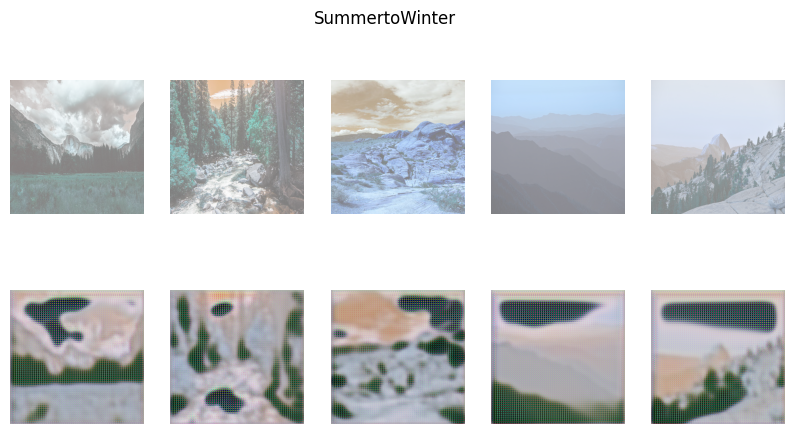

1/1 [==============================] - 6s 6s/step


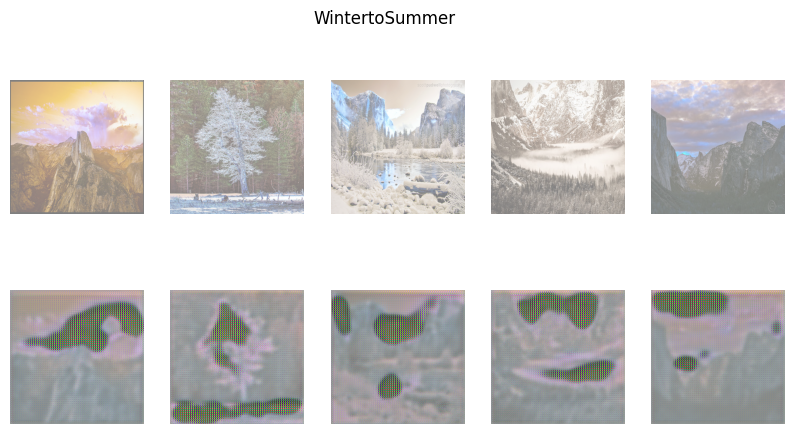

1/1 [==============================] - 1s 1s/step
Iteration>151, dA[0.076,0.041] dB[0.109,0.092] g[8.979,9.173]
1/1 [==============================] - 1s 1s/step
Iteration>152, dA[0.104,0.070] dB[0.052,0.089] g[9.411,9.715]
1/1 [==============================] - 1s 1s/step
Iteration>153, dA[0.320,0.300] dB[0.104,0.061] g[9.188,9.778]
1/1 [==============================] - 1s 1s/step
Iteration>154, dA[0.135,0.024] dB[0.037,0.099] g[7.324,8.418]
1/1 [==============================] - 1s 1s/step
Iteration>155, dA[0.177,0.019] dB[0.100,0.077] g[10.775,10.657]
1/1 [==============================] - 1s 1s/step
Iteration>156, dA[0.085,0.049] dB[0.086,0.062] g[7.414,7.380]
1/1 [==============================] - 1s 1s/step
Iteration>157, dA[0.189,0.078] dB[0.037,0.074] g[7.063,7.118]
1/1 [==============================] - 1s 1s/step
Iteration>158, dA[0.048,0.047] dB[0.043,0.072] g[7.050,6.972]
1/1 [==============================] - 1s 1s/step
Iteration>159, dA[0.062,0.031] dB[0.058,0.035] g[6.2

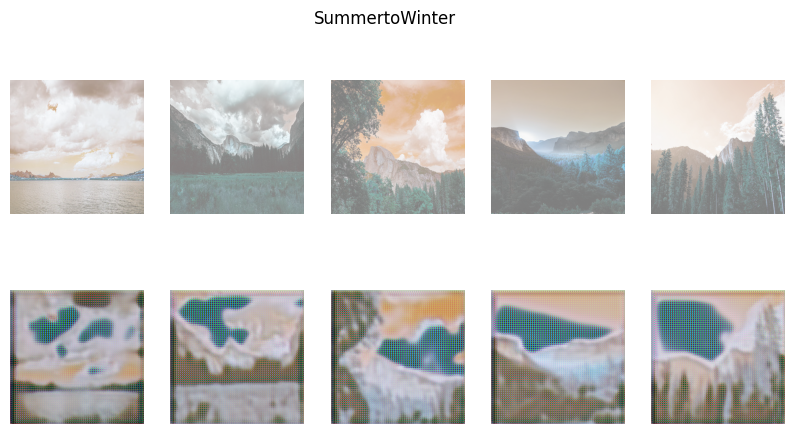

1/1 [==============================] - 7s 7s/step


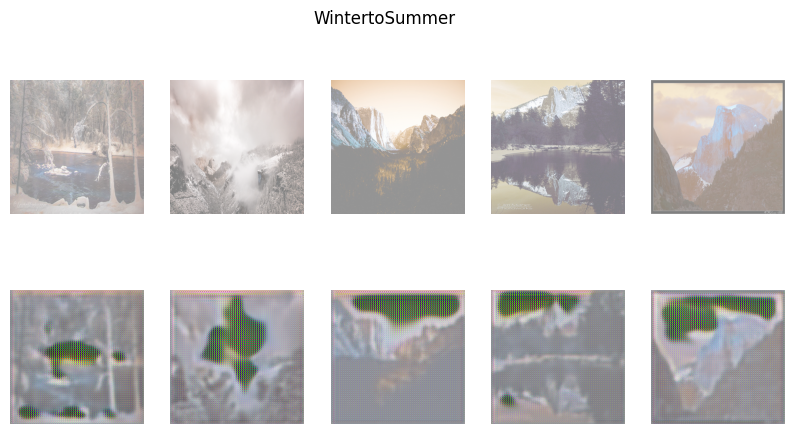

1/1 [==============================] - 3s 3s/step
Iteration>201, dA[0.022,0.066] dB[0.116,0.091] g[9.327,9.760]
1/1 [==============================] - 1s 1s/step
Iteration>202, dA[0.108,0.030] dB[0.081,0.018] g[5.776,5.570]
1/1 [==============================] - 1s 1s/step
Iteration>203, dA[0.037,0.054] dB[0.127,0.064] g[13.697,11.629]
1/1 [==============================] - 1s 1s/step
Iteration>204, dA[0.086,0.209] dB[0.042,0.024] g[13.625,12.129]
1/1 [==============================] - 1s 1s/step
Iteration>205, dA[0.027,0.121] dB[0.055,0.035] g[7.930,7.733]
1/1 [==============================] - 1s 1s/step
Iteration>206, dA[0.084,0.047] dB[0.144,0.090] g[6.781,6.635]
1/1 [==============================] - 1s 1s/step
Iteration>207, dA[0.052,0.059] dB[0.038,0.082] g[7.118,6.241]
1/1 [==============================] - 1s 1s/step
Iteration>208, dA[0.051,0.108] dB[0.175,0.020] g[7.164,7.186]
1/1 [==============================] - 1s 1s/step
Iteration>209, dA[0.058,0.015] dB[0.039,0.038] g[6

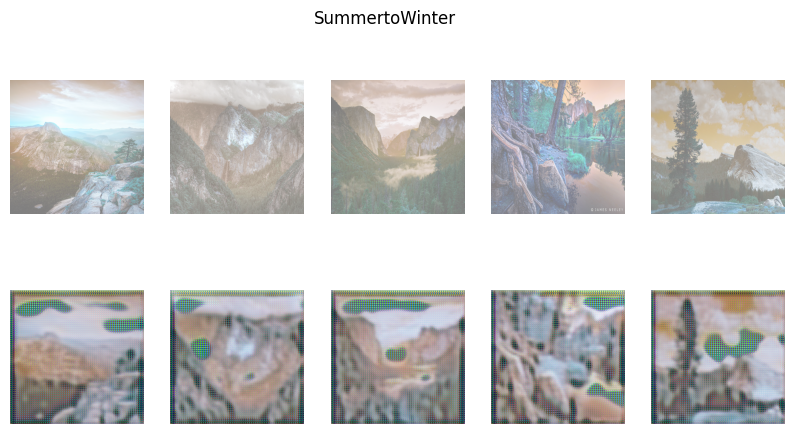

1/1 [==============================] - 6s 6s/step


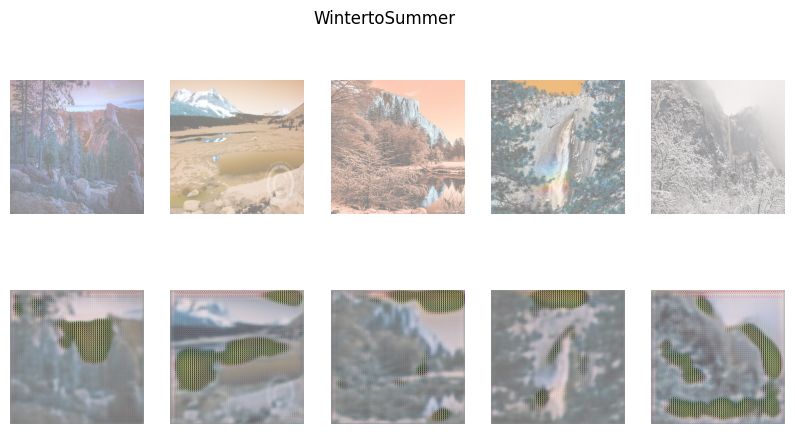

In [293]:
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

In [ ]:
# The results are not so satisfactory cause i was not able to train it with enough time. 